### Cab-Driver Agent

In [23]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Flatten, Activation, Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [24]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [25]:
Time_matrix.shape

(5, 5, 24, 7)

In [26]:
Time_matrix[0,4,3,2]

1.0

#### Tracking the state-action pairs for checking convergence


In [27]:
states_dict = collections.defaultdict(dict)

In [28]:
# Initialise the states to be tracked
def initialise_states_dict():
    sample_q_vals = [((0, 0, 0), (0, 1)), ((0, 0, 0), (0, 2)),((0, 0, 0), (0, 3)), ((0, 0, 0), (0, 4)) ]    
    for q_vals in sample_q_vals:
        state = q_vals[0]
        action = q_vals[1]
        states_dict[state][action] = []

In [29]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [30]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001
        self.epsilon_max = self.epsilon = 1
        self.epsilon_decay = 0.01
        self.epsilon_min = 0.00001

        self.batch_size = 32
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets   
        
        # input layer
        model.add(Dense(32, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
        
        # layer - 2
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # layer - 3
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # output layer
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, action_space, possible_actions):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            index = random.randrange(len(possible_actions))
            action_index = possible_actions[index]
            action = action_space[action_index]
            return action_index, action

        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so reshape state to (1, state_size) so that the first index corresponds to the batch size

            state = np.array(state).reshape(1, self.state_size)
            q_val = self.model.predict(state)

            return np.argmax(q_val[0]), action_space[np.argmax(q_val[0])]

    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):

        if len(self.memory) > self.batch_size:
           
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))  
            update_input = np.zeros((self.batch_size, self.state_size))

            actions, rewards = [], []

            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state

                # Write your code from here
                # 1. Predict the target from earlier model
                target = self.model.predict(update_input)

                # 2. Get the target for the Q-network
                target_qval = self.model.predict(update_output)

                # 3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    # Method to save the model
    def save(self, name):
        self.model.save(name)         
    
    # Method to store the q-values
    def store_q_vals(self):
        q_val = self.model.predict(self.track_state)
        self.states_tracked.append(q_val[0][2])

In [31]:
# Randomly select the number of eposodes
Episodes = 600

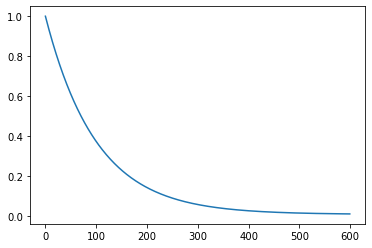

In [32]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
epsilon = []
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.01

# return evenly spaced values between 0 and 600 (number of episodes)
episodes = np.arange(0, Episodes)
for episode in episodes:
    epsilon.append(min_epsilon +
                   (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * episode))

# Show the plot between the number of episodes and epsilon values
plt.plot(episodes, epsilon)
plt.show()

### DQN block

In [33]:
# get the current time
start_time = time.time()


rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []

env = CabDriver()
agent = DQNAgent(action_size=len(env.action_space), state_size=len(env.state_encod_arch1(
    env.state_init)))

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    score = 0
    total_time = 0
    terminal_state = False
    action_space, state_space, state = env.reset()
       
    while  not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index, actions = env.requests(state)
        action_index, action = agent.get_action(env.state_encod_arch1(state), env.action_space, possible_actions_index)
        
        # 2. Evaluate your reward and next state
        next_state, wait_time, transit_time, ride_time = env.next_state_func(state, action, Time_matrix)
        reward = env.reward_func(state, action, Time_matrix)
        
        # 3. Append the experience to the memory
        agent.append_sample(env.state_encod_arch1(state), action_index, reward, env.state_encod_arch1(next_state))
        
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
        total_time += wait_time + transit_time + ride_time
        
        if total_time >= 24 * 30:
            print("state terminated")
            terminal_state = True

     # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)

    # every episode
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode, score, len(agent.memory), agent.epsilon))
    
    # every 10 episodes:
    if episode % 10 == 0:
        agent.store_q_vals()  # store q-values of some prespecified state-action pairs
    if episode % 1000 == 0:
        agent.save(name="model.pkl")
        time_taken = time.time() - start_time
        print('Time taken still now :', time_taken)  

state terminated
episode 0, reward 156.0, memory_length 132, epsilon 1.0
INFO:tensorflow:Assets written to: model.pkl/assets
Time taken still now : 168.7699840068817
state terminated
episode 1, reward -56.0, memory_length 292, epsilon 0.9900499332508306
state terminated
episode 2, reward -322.0, memory_length 441, epsilon 0.9801988713200221
state terminated
episode 3, reward -239.0, memory_length 587, epsilon 0.9704458290931727
state terminated
episode 4, reward -202.0, memory_length 727, epsilon 0.9607898312579316
state terminated
episode 5, reward -199.0, memory_length 863, epsilon 0.951229912206469
state terminated
episode 6, reward -106.0, memory_length 1008, epsilon 0.9417651159389129
state terminated
episode 7, reward -114.0, memory_length 1133, epsilon 0.9323944959677493
state terminated
episode 8, reward 126.0, memory_length 1277, epsilon 0.9231171152231719
state terminated
episode 9, reward 210.0, memory_length 1416, epsilon 0.9139320459593755
state terminated
episode 10, rewa

state terminated
episode 91, reward 1364.0, memory_length 2000, epsilon 0.4025301987913957
state terminated
episode 92, reward 1574.0, memory_length 2000, epsilon 0.3985250558941033
state terminated
episode 93, reward 1603.0, memory_length 2000, epsilon 0.3945597648344974
state terminated
episode 94, reward 1314.0, memory_length 2000, epsilon 0.39063392908016753
state terminated
episode 95, reward 1498.0, memory_length 2000, epsilon 0.3867471560442667
state terminated
episode 96, reward 1754.0, memory_length 2000, epsilon 0.3828990570462523
state terminated
episode 97, reward 1208.0, memory_length 2000, epsilon 0.37908924727301785
state terminated
episode 98, reward 1688.0, memory_length 2000, epsilon 0.3753173457404111
state terminated
episode 99, reward 1530.0, memory_length 2000, epsilon 0.3715829752551355
state terminated
episode 100, reward 1713.0, memory_length 2000, epsilon 0.36788576237703063
state terminated
episode 101, reward 1339.0, memory_length 2000, epsilon 0.36422533738

state terminated
episode 180, reward 2214.0, memory_length 2000, epsilon 0.16530723523270432
state terminated
episode 181, reward 1884.0, memory_length 2000, epsilon 0.16366250026133602
state terminated
episode 182, reward 2191.0, memory_length 2000, epsilon 0.16203413067637143
state terminated
episode 183, reward 2313.0, memory_length 2000, epsilon 0.160421963639495
state terminated
episode 184, reward 2178.0, memory_length 2000, epsilon 0.1588258379326596
state terminated
episode 185, reward 1844.0, memory_length 2000, epsilon 0.1572455939419645
state terminated
episode 186, reward 1966.0, memory_length 2000, epsilon 0.15568107364169365
state terminated
episode 187, reward 1691.0, memory_length 2000, epsilon 0.15413212057851328
state terminated
episode 188, reward 2037.0, memory_length 2000, epsilon 0.1525985798558263
state terminated
episode 189, reward 2142.0, memory_length 2000, epsilon 0.1510802981182825
state terminated
episode 190, reward 2104.0, memory_length 2000, epsilon 0.1

state terminated
episode 269, reward 2290.0, memory_length 2000, epsilon 0.06789026056236773
state terminated
episode 270, reward 2358.0, memory_length 2000, epsilon 0.06721484068462236
state terminated
episode 271, reward 2199.0, memory_length 2000, epsilon 0.06654614134694971
state terminated
episode 272, reward 2272.0, memory_length 2000, epsilon 0.06588409567885868
state terminated
episode 273, reward 2079.0, memory_length 2000, epsilon 0.06522863747523085
state terminated
episode 274, reward 2286.0, memory_length 2000, epsilon 0.06457970118969954
state terminated
episode 275, reward 2181.0, memory_length 2000, epsilon 0.0639372219280955
state terminated
episode 276, reward 2553.0, memory_length 2000, epsilon 0.0633011354419571
state terminated
episode 277, reward 1973.0, memory_length 2000, epsilon 0.06267137812210573
state terminated
episode 278, reward 2556.0, memory_length 2000, epsilon 0.06204788699228452
state terminated
episode 279, reward 2460.0, memory_length 2000, epsilon

state terminated
episode 357, reward 2482.0, memory_length 2000, epsilon 0.028165572121763294
state terminated
episode 358, reward 2522.0, memory_length 2000, epsilon 0.027885419498264463
state terminated
episode 359, reward 2568.0, memory_length 2000, epsilon 0.027608054439945056
state terminated
episode 360, reward 2426.0, memory_length 2000, epsilon 0.027333449210068087
state terminated
episode 361, reward 2404.0, memory_length 2000, epsilon 0.02706157634788175
state terminated
episode 362, reward 2239.0, memory_length 2000, epsilon 0.02679240866587325
state terminated
episode 363, reward 2340.0, memory_length 2000, epsilon 0.026525919247050094
state terminated
episode 364, reward 2339.0, memory_length 2000, epsilon 0.026262081442248304
state terminated
episode 365, reward 2495.0, memory_length 2000, epsilon 0.02600086886746756
state terminated
episode 366, reward 2428.0, memory_length 2000, epsilon 0.025742255401232678
state terminated
episode 367, reward 2285.0, memory_length 2000

state terminated
episode 445, reward 2325.0, memory_length 2000, epsilon 0.01168845018472574
state terminated
episode 446, reward 2473.0, memory_length 2000, epsilon 0.01157224766383566
state terminated
episode 447, reward 2505.0, memory_length 2000, epsilon 0.011457201377347206
state terminated
episode 448, reward 2466.0, memory_length 2000, epsilon 0.01134329982053584
state terminated
episode 449, reward 2374.0, memory_length 2000, epsilon 0.011230531603150988
state terminated
episode 450, reward 2289.0, memory_length 2000, epsilon 0.011118885448276924
state terminated
episode 451, reward 2343.0, memory_length 2000, epsilon 0.011008350191205123
state terminated
episode 452, reward 2434.0, memory_length 2000, epsilon 0.010898914778317755
state terminated
episode 453, reward 2568.0, memory_length 2000, epsilon 0.010790568265982356
state terminated
episode 454, reward 2447.0, memory_length 2000, epsilon 0.01068329981945739
state terminated
episode 455, reward 2371.0, memory_length 2000,

state terminated
episode 533, reward 2547.0, memory_length 2000, epsilon 0.004854021571548845
state terminated
episode 534, reward 2573.0, memory_length 2000, epsilon 0.004805822751589318
state terminated
episode 535, reward 2633.0, memory_length 2000, epsilon 0.004758103517901479
state terminated
episode 536, reward 2586.0, memory_length 2000, epsilon 0.0047108590985222
state terminated
episode 537, reward 2593.0, memory_length 2000, epsilon 0.0046640847689701686
state terminated
episode 538, reward 2532.0, memory_length 2000, epsilon 0.004617775851773451
state terminated
episode 539, reward 2655.0, memory_length 2000, epsilon 0.004571927716001739
state terminated
episode 540, reward 2439.0, memory_length 2000, epsilon 0.00452653577680324
state terminated
episode 541, reward 2424.0, memory_length 2000, epsilon 0.004481595494946218
state terminated
episode 542, reward 2595.0, memory_length 2000, epsilon 0.004437102376365033
state terminated
episode 543, reward 2577.0, memory_length 200

In [34]:
total_time = time.time() - start_time
print('Total time : ',total_time)

Total time :  125622.99353384972


### Tracking Convergence

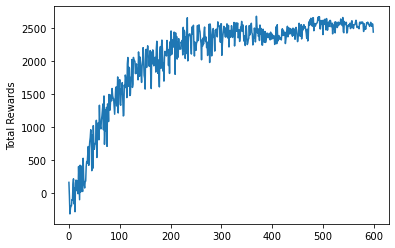

In [35]:
# Check Convergence
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("Total Rewards")
plt.show()

In [ ]:
#### Above graph shows that rewards reached convergence at around 200 and there is no progressive increment in rewards after that.

In [36]:
# Average rewards per 100 episodes
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward / index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward / index)   
print(avg_rewards)

[722.63, 1894.26, 2313.2, 2408.87, 2457.09, 2541.46]


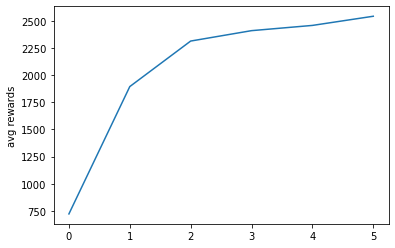

In [37]:
# Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

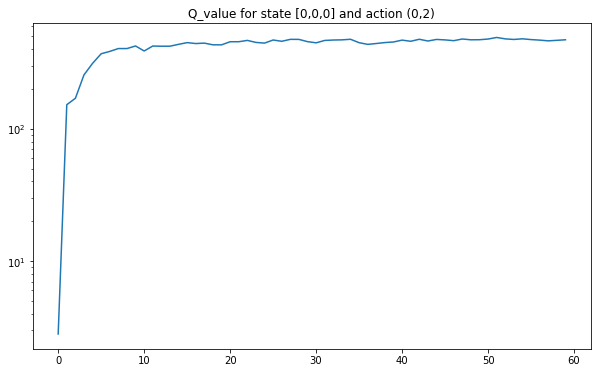

In [38]:
plt.figure(0, figsize=(10,6))
plt.title('Q_value for state [0,0,0] and action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

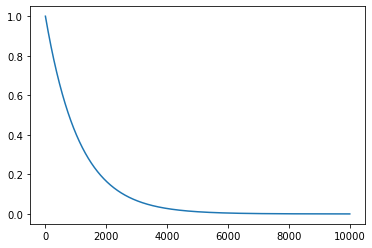

In [11]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))
plt.plot(time, epsilon)
plt.show()

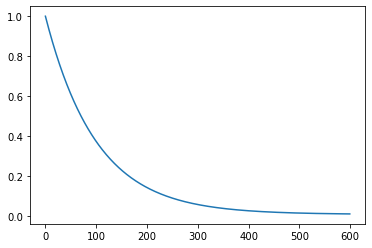

In [16]:
epsilon = []
max_epsilon = 1.0
min_epsilon = 0.01
episodes = np.arange(0,600)
for episode in episodes:
    epsilon.append(min_epsilon +
                   (max_epsilon - min_epsilon) * np.exp(-0.01 * episode))
plt.plot(episodes, epsilon)
plt.show()